In [1]:
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

Using cache found in C:\Users\Vikram.Melapudi/.cache\torch\hub\facebookresearch_dinov2_main


image1.shape: (421, 457, 3)
mask1.shape: (421, 457)
image_tensor1.shape: torch.Size([3, 448, 476])
grid_size1: (32, 34)
resize_scale1: 0.9403292181069959


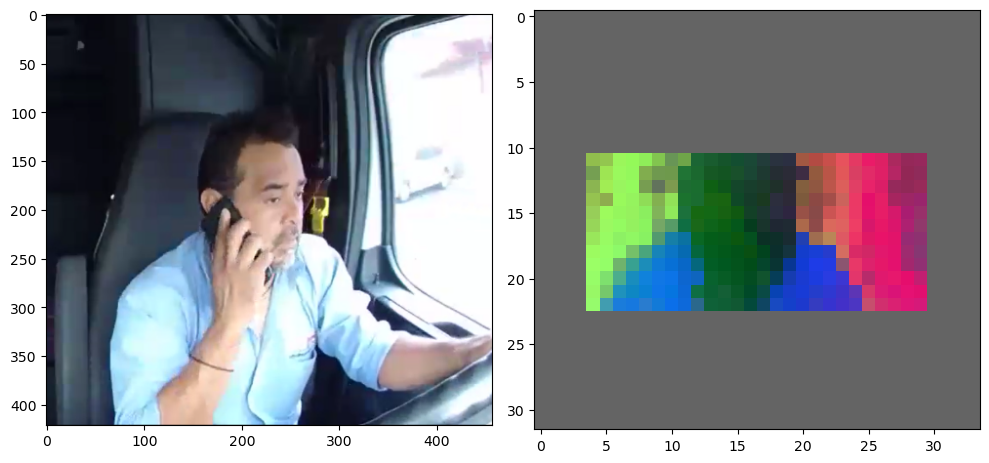

In [33]:
class Dinov2Matcher:

  def __init__(self, repo_name="facebookresearch/dinov2", 
               model_name="dinov2_vitb14", smaller_edge_size=448, half_precision=False, device="cpu"):
    self.repo_name = repo_name
    self.model_name = model_nameg
    self.smaller_edge_size = smaller_edge_size
    self.half_precision = half_precision
    self.device = device

    if self.half_precision:
      self.model = torch.hub.load(repo_or_dir=repo_name, model=model_name).half().to(self.device)
    else:
      self.model = torch.hub.load(repo_or_dir=repo_name, model=model_name).to(self.device)

    self.model.eval()

    self.transform = transforms.Compose([
        transforms.Resize(size=smaller_edge_size, interpolation=transforms.InterpolationMode.BICUBIC, antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # imagenet defaults
      ])

  # https://github.com/facebookresearch/dinov2/blob/255861375864acdd830f99fdae3d9db65623dafe/notebooks/features.ipynb
  def prepare_image(self, rgb_image_numpy):
    image = Image.fromarray(rgb_image_numpy)
    image_tensor = self.transform(image)
    resize_scale = image.width / image_tensor.shape[2]

    # Crop image to dimensions that are a multiple of the patch size
    height, width = image_tensor.shape[1:] # C x H x W
    cropped_width, cropped_height = width - width % self.model.patch_size, height - height % self.model.patch_size # crop a bit from right and bottom parts
    image_tensor = image_tensor[:, :cropped_height, :cropped_width]

    grid_size = (cropped_height // self.model.patch_size, cropped_width // self.model.patch_size)
    return image_tensor, grid_size, resize_scale
  
  def prepare_mask(self, mask_image_numpy, grid_size, resize_scale):
    cropped_mask_image_numpy = mask_image_numpy[:int(grid_size[0]*self.model.patch_size*resize_scale), :int(grid_size[1]*self.model.patch_size*resize_scale)]
    image = Image.fromarray(cropped_mask_image_numpy)
    resized_mask = image.resize((grid_size[1], grid_size[0]), resample=Image.Resampling.NEAREST)
    resized_mask = np.asarray(resized_mask).flatten()
    return resized_mask
  
  def extract_features(self, image_tensor):
    with torch.inference_mode():
      if self.half_precision:
        image_batch = image_tensor.unsqueeze(0).half().to(self.device)
      else:
        image_batch = image_tensor.unsqueeze(0).to(self.device)

      tokens = self.model.get_intermediate_layers(image_batch)[0].squeeze()
    return tokens.cpu().numpy()
  
  def idx_to_source_position(self, idx, grid_size, resize_scale):
    row = (idx // grid_size[1])*self.model.patch_size*resize_scale + self.model.patch_size / 2
    col = (idx % grid_size[1])*self.model.patch_size*resize_scale + self.model.patch_size / 2
    return row, col
  
  def get_embedding_visualization(self, tokens, grid_size, resized_mask=None):
    pca = PCA(n_components=3)
    if resized_mask is not None:
      tokens = tokens[resized_mask]
    reduced_tokens = pca.fit_transform(tokens.astype(np.float32))
    if resized_mask is not None:
      tmp_tokens = np.zeros((*resized_mask.shape, 3), dtype=reduced_tokens.dtype)
      tmp_tokens[resized_mask] = reduced_tokens
      reduced_tokens = tmp_tokens
    reduced_tokens = reduced_tokens.reshape((*grid_size, -1))
    normalized_tokens = (reduced_tokens-np.min(reduced_tokens))/(np.max(reduced_tokens)-np.min(reduced_tokens))
    return normalized_tokens

# Load image and mask
image1 = cv2.cvtColor(cv2.imread('asd1.jpg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
# mask1 = cv2.imread('asd1_mask.jpg', cv2.IMREAD_COLOR)[:,:,0] > 127

image1 = cv2.cvtColor(cv2.imread('ph1.png', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
mask1 = np.zeros(image1.shape[:2], np.uint8) 
mask1[100:500, 100:400] = 1
mask1 = mask1>0

# Init Dinov2Matcher
dm = Dinov2Matcher(half_precision=False)

# Extract features
image_tensor1, grid_size1, resize_scale1 = dm.prepare_image(image1)
features1 = dm.extract_features(image_tensor1)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,20))
ax1.imshow(image1)
resized_mask = dm.prepare_mask(mask1, grid_size1, resize_scale1)
vis_image = dm.get_embedding_visualization(features1, grid_size1, resized_mask)
ax2.imshow(vis_image)
fig.tight_layout()

# More info
print("image1.shape:", image1.shape)
print("mask1.shape:", mask1.shape)
print("image_tensor1.shape:", image_tensor1.shape)
print("grid_size1:", grid_size1)
print("resize_scale1:", resize_scale1)

In [36]:
grid_size1, resize_scale1, grid_size2, resize_scale2

((32, 34), 0.9403292181069959, (33, 32), 0.9129464285714286)

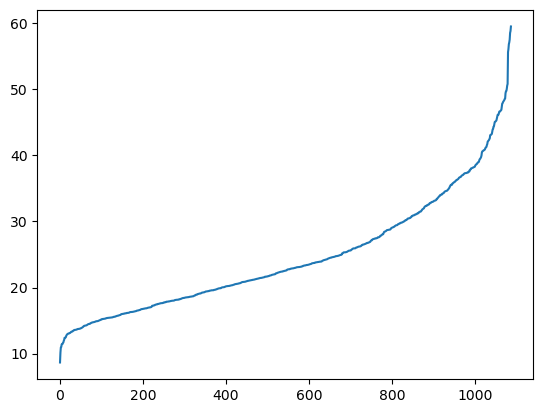

In [60]:
# Extract image1 features
# image1 = cv2.cvtColor(cv2.imread('asd1.jpg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
# mask1 = cv2.imread('asd1_mask.jpg', cv2.IMREAD_COLOR)[:,:,0] > 127

image1 = cv2.cvtColor(cv2.imread('ph3.png', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
image1 = image1[300:,800:1200]
image_tensor1, grid_size1, resize_scale1 = dm.prepare_image(image1)
features1 = dm.extract_features(image_tensor1)

# Extract image2 features
# image2 = cv2.cvtColor(cv2.imread('asd2.jpg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
# mask2 = cv2.imread('asd2_mask.jpg', cv2.IMREAD_COLOR)[:,:,0] > 127
image2 = cv2.cvtColor(cv2.imread('ph1.png', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
mask2 = np.zeros(image2.shape[:2], np.uint8) 
mask2[100:500, 100:400] = 1
mask2 = mask2>0


image_tensor2, grid_size2, resize_scale2 = dm.prepare_image(image2)
features2 = dm.extract_features(image_tensor2)

# Build knn using features from image1, and query all features from image2
knn = NearestNeighbors(n_neighbors=1)
knn.fit(features1)
distances, match2to1 = knn.kneighbors(features2)
match2to1 = np.array(match2to1)

plt.plot(sorted(distances))

1088 12


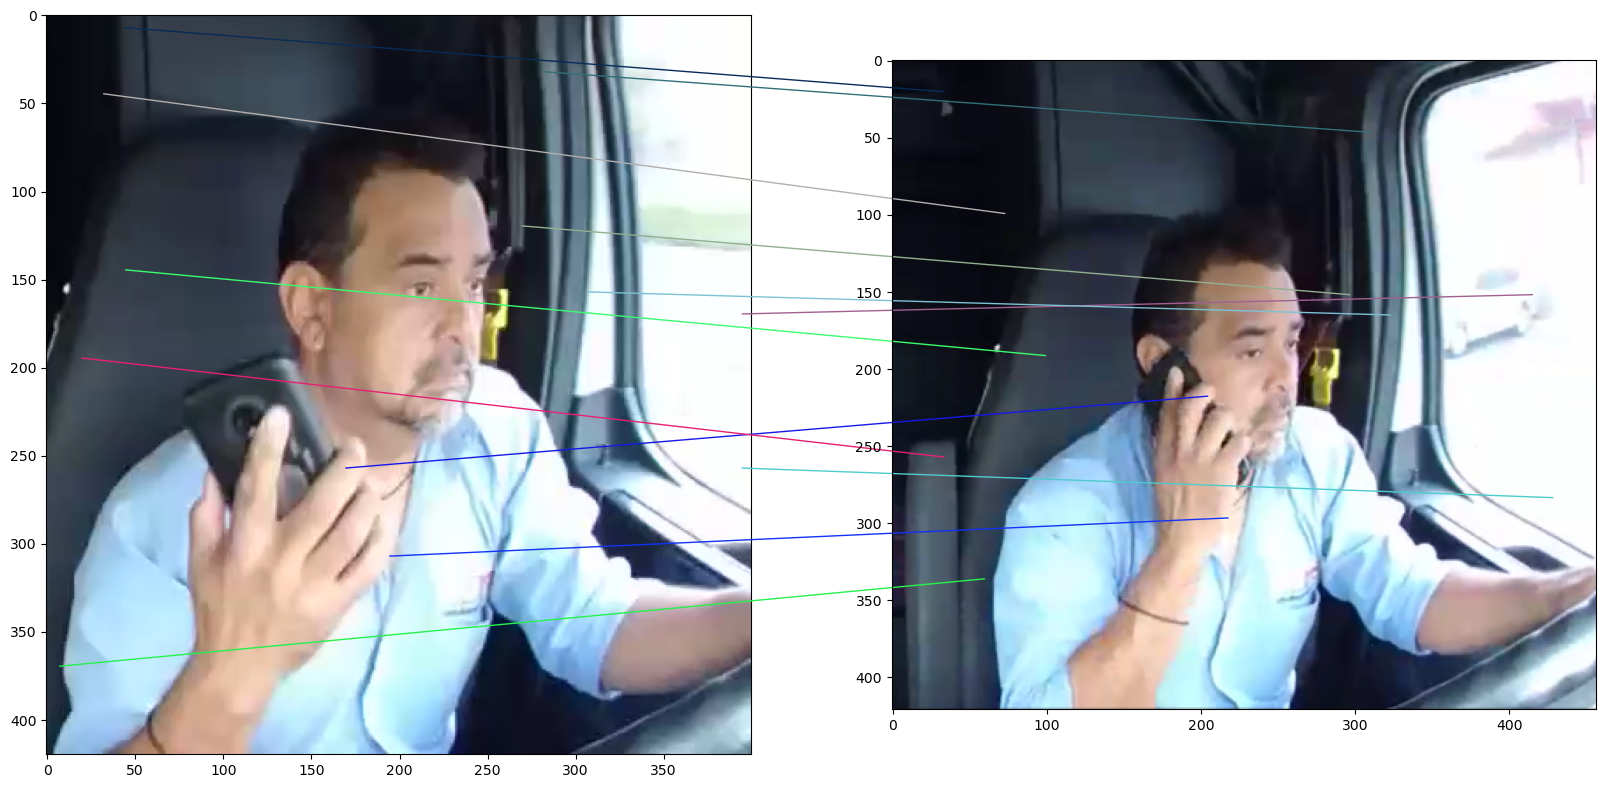

In [62]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(image1)
ax2.imshow(image2)

nplts = 0
for idx2, (dist, idx1) in enumerate(zip(distances, match2to1)):
  row, col = dm.idx_to_source_position(idx1, grid_size1, resize_scale1)
  xyA = (col, row)
#   if not mask1[int(row), int(col)]: continue # skip if feature is not on the object

  row, col = dm.idx_to_source_position(idx2, grid_size2, resize_scale2)
  xyB = (col, row)
#   if not mask2[int(row), int(col)]: continue # skip if feature is not on the object

  if np.random.rand() > 0.01: continue # sparsely draw so that we can see the lines...
  nplts += 1
  con = ConnectionPatch(xyA=xyB, xyB=xyA, coordsA="data", coordsB="data",
                        axesA=ax2, axesB=ax1, color=np.random.rand(3,))
  ax2.add_artist(con)
print(len(match2to1), nplts)

<IPython.core.display.Javascript object>


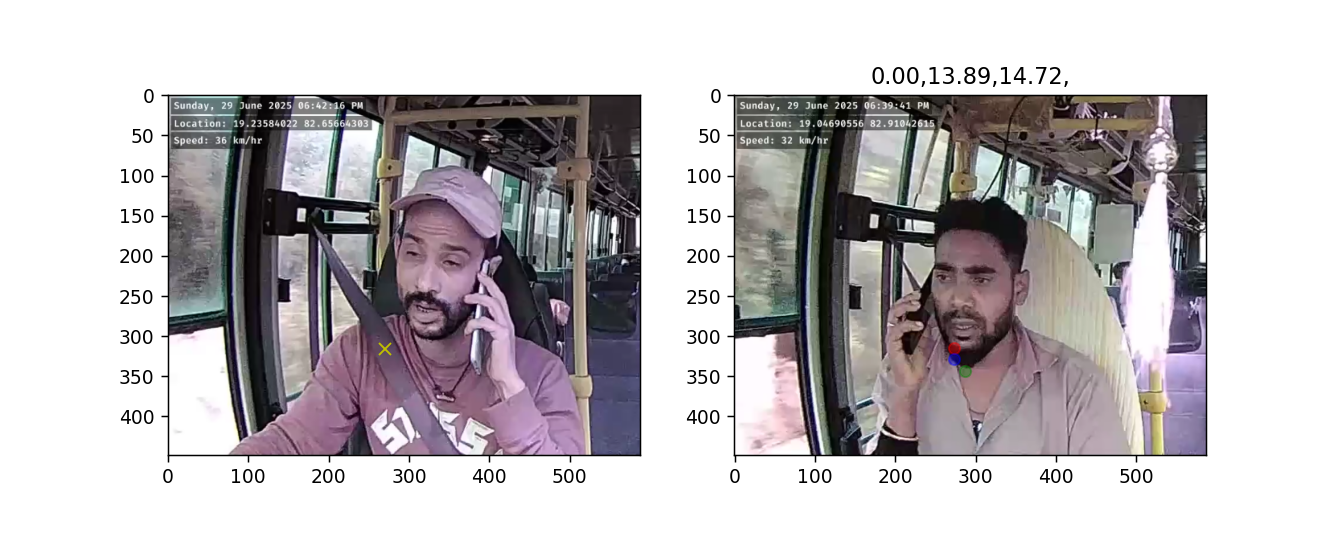

In [342]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Button, HBox, VBox
import os
import glob

# actions = ['Load Hist', 'Refresh', 'Left Half', 'Right Half']

dbg = []

def getImageFiles(rdir='./', types=['jgp','JPG','jpeg','png']):
    fils = []
    for typ in  types:
        fils += glob.glob(rdir+'*.'+typ)
    return fils

def tensor2Image(tensor):
    image = np.array(tensor)
    image = np.transpose(image,[1,2,0])
    print(image.shape)
    mean=(0.485, 0.456, 0.406)
    std=(0.229, 0.224, 0.225) # imagenet defaults
    for n in range(3):
        image[:,:,n] = np.clip(image[:,:,n]*std[n]+mean[n], 0, 255).astype(int)
    return image

def procImage(ffil, forceLoad=False):
    image1 = cv2.cvtColor(cv2.imread(ffil, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    npyFile= (ffil+'_feats.npz')
    if os.path.isfile(npyFile) and (not forceLoad):
        d = np.load(npyFile)
        features1 = d['features']
        grid_size1 = d['grid_size']
        resize_scale1 = d['resize_scale']
        image = d['image']
        patch_size1 = d['patch_size']
    else:
        image_tensor1, grid_size1, resize_scale1 = dm.prepare_image(image1)
        features1 = dm.extract_features(image_tensor1)
        image = cv2.resize(image1,(image_tensor1.shape[2],image_tensor1.shape[1]))
        patch_size1 = dm.model.patch_size
        np.savez(npyFile, image=image, grid_size=grid_size1, 
                 resize_scale=resize_scale1, features=features1,
                 patch_size=patch_size1)
    knn = NearestNeighbors(n_neighbors=1)
    knn.fit(features1)
    info ='size=%dx%d, grids=%dx%d, feats=%d'%(image.shape[0],image.shape[1], grid_size1[0], grid_size1[1], len(features1))
    
    return {'grid_size':grid_size1, 
            'image': image,
            'patch_size': patch_size1,
            'features': features1, 
            'resize_scale':resize_scale1, 
            'knn':knn,
            'info': info
           }

def xy2Index(x, y, obj):
    row = int(y//obj['patch_size'])
    col = int(x//obj['patch_size'])
    xGrids = obj['grid_size'][1]
    idx = row*xGrids + col
    return idx

def index2xy(idx, obj):
    psz = obj['patch_size']
    gsz = obj['grid_size']
    
    row = idx//gsz[1]
    col = idx%gsz[1]
    
    y = row*psz + psz*0.5
    x = col*psz + psz*0.5
    
    return [x,y]

def getFeats(N, x, y, src2tar=True):
    if src2tar:
        idx = xy2Index(x,y,src)
        dist, nindx = tar['knn'].kneighbors(src['features'][idx:idx+1], N)
        xys = []
        for nn, n in enumerate(nindx[0]):
            xys.append(index2xy(n,tar)+ [dist[0][nn]])
    else:
        idx = xy2Index(x,y,tar)
        dist, nindx = src['knn'].kneighbors(tar['features'][idx:idx+1], N)
        xys = []
        for nn, n in enumerate(nindx[0]):
            xys.append(index2xy(n,src)+[dist[0][nn]])
    return xys

def setSource(name):
    global src
    wInfo.value = 'Source='+name['new'];
    src = procImage(name['new'])
    ax[0].imshow(src['image'])
    
def setTarget(name):
    global tar
    wInfo.value = 'Target='+name['new'];
    tar = procImage(name['new'])
    ax[1].imshow(tar['image'])
    
allFiles = getImageFiles()
wTarget = widgets.Dropdown(
    options=allFiles,
    value=allFiles[0],
    description='Target:',
    disabled=False,
)
wSource = widgets.Dropdown(
    options=allFiles,
    value=allFiles[0],
    description='Source:',
    disabled=False,
)
wInfo = widgets.HTML(
    value="Hello <b>World</b>",
    placeholder='Info:',
    description='Info:',
)
wSource.observe(setSource, names='value')
wTarget.observe(setTarget, names='value')

wHBox1 = HBox([wSource, wTarget])
wHBox2 = HBox([wInfo])
wVBox = VBox([wHBox1, wHBox2])

def processClick(x,y,src2tar):
    global dbg
    dbg.append((3, x, y, src2tar))
    patches = getFeats(3, x, y, src2tar)
    wInfo.value = str(patches)

    ax[0].clear()
    ax[1].clear()
    ax[0].imshow(src['image'])
    ax[1].imshow(tar['image'])
    cols = ['r','g','b','y','m']
    dtxt = ''
    replotIndex = 1
    if src2tar:
        ax[0].plot(x,y,'yx')
        for npatch, patch in enumerate(patches):
            ax[1].plot(patch[0], patch[1], cols[npatch]+'o', alpha=0.4, )#, marker_size=2)
            dtxt += '%1.2f,'%patch[2]
        ax[1].set_title(dtxt)
    else:
        ax[1].plot(x,y,'yx')
        for npatch, patch in enumerate(patches):
            ax[0].plot(patch[0], patch[1], cols[npatch]+'o', alpha=0.4,)#, marker_size=2)
            dtxt += '%1.2f,'%patch[2]
        ax[0].set_title(dtxt)

def onclick(event):
    global dbg
    wInfo.vlaue = 'here'
    if event.xdata is not None and event.ydata is not None:
        txt = f"Clicked at: x={event.xdata}, y={event.ydata} ({event.x},{event.y})"
        dbg.append(txt)
        wInfo.value = txt
        
        src2tar = True
        if event.x>fig.get_window_extent().width/2:
            src2tar = False

        processClick(event.xdata, event.ydata, src2tar)

wInfo.value = "test"
display(wVBox)

fig, ax = plt.subplots(1,2)
ax[0].plot([0, 1], [0, 1])
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

<IPython.core.display.Javascript object>


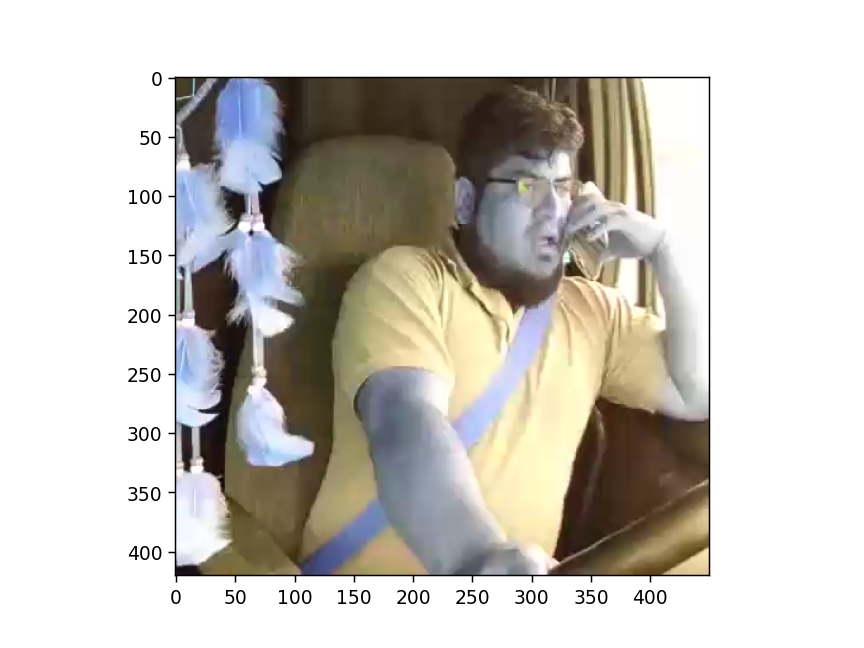

In [298]:
ffil = 'ph4.png'
image = cv2.imread(ffil)
image = image[300:,750:1200]
cv2.imwrite(ffil, image)
plt.figure()
plt.imshow(image)
plt.show()
# os.remove('ph3.png_feats.npz')